# Sensor Data Analysis

This notebook computes differences between sensor 17 and sensor 20 at each timestamp for temperature, humidity, irradiance, and power.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Read data from both sensor files
sensor_17_file = 'data/sensor_17_combined_data.xlsx'
sensor_20_file = 'data/sensor_20_combined_data.xlsx'

df_17 = pd.read_excel(sensor_17_file)
df_20 = pd.read_excel(sensor_20_file)

print("Sensor 17 data:")
print(f"  Shape: {df_17.shape}")
print(f"  Columns: {df_17.columns.tolist()}")
print(f"  Time range: {df_17['datetime'].min()} to {df_17['datetime'].max()}")
print(f"\nSensor 20 data:")
print(f"  Shape: {df_20.shape}")
print(f"  Columns: {df_20.columns.tolist()}")
print(f"  Time range: {df_20['datetime'].min()} to {df_20['datetime'].max()}")


Sensor 17 data:
  Shape: (11561, 6)
  Columns: ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'sensor_id', 'power_W']
  Time range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00

Sensor 20 data:
  Shape: (10553, 6)
  Columns: ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'sensor_id', 'power_W']
  Time range: 2025-08-19 17:10:00 to 2025-10-31 23:50:00


In [7]:
# Ensure datetime columns are datetime type
df_17['datetime'] = pd.to_datetime(df_17['datetime'])
df_20['datetime'] = pd.to_datetime(df_20['datetime'])

# Merge on datetime to align timestamps
# Use inner join to keep only timestamps present in both sensors
merged = pd.merge(
    df_17[['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'power_W']],
    df_20[['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'power_W']],
    on='datetime',
    how='inner',
    suffixes=('_17', '_20')
)

print(f"Merged data shape: {merged.shape}")
print(f"Common timestamps: {len(merged)}")
print(f"Time range: {merged['datetime'].min()} to {merged['datetime'].max()}")
print(f"\nFirst few rows:")
print(merged.head(10))


Merged data shape: (10553, 9)
Common timestamps: 10553
Time range: 2025-08-19 17:10:00 to 2025-10-31 23:50:00

First few rows:
             datetime  upper_temp_C_17  upper_humidity_17  \
0 2025-08-19 17:10:00        33.333760          54.885674   
1 2025-08-19 17:20:00        33.017238          57.869201   
2 2025-08-19 17:30:00        32.599933          57.003644   
3 2025-08-19 17:40:00        32.951847          54.724692   
4 2025-08-19 17:50:00        33.333411          56.330882   
5 2025-08-19 18:00:00        33.342280          55.844942   
6 2025-08-19 18:10:00        32.909700          55.547837   
7 2025-08-19 18:20:00        32.397005          55.972080   
8 2025-08-19 18:30:00        32.036938          56.765424   
9 2025-08-19 18:40:00        31.478619          60.094326   

   upper_irradiance_17  power_W_17  upper_temp_C_20  upper_humidity_20  \
0         12810.177744   5148.8320        33.372080          56.480183   
1         12349.218765   1224.8640        32.911531  

In [8]:
# Compute differences (sensor_20 - sensor_17) for each factor
differences = pd.DataFrame()
differences['datetime'] = merged['datetime']

# Calculate differences
differences['temp_diff_C'] = merged['upper_temp_C_20'] - merged['upper_temp_C_17']
differences['humidity_diff_pct'] = merged['upper_humidity_20'] - merged['upper_humidity_17']
differences['irradiance_diff'] = merged['upper_irradiance_20'] - merged['upper_irradiance_17']
differences['power_diff_W'] = merged['power_W_20'] - merged['power_W_17']

# Sort by datetime
differences = differences.sort_values('datetime').reset_index(drop=True)

print("Differences (Sensor 20 - Sensor 17):")
print(f"Data shape: {differences.shape}")
print(f"\nFirst few rows:")
print(differences.head(20))
print(f"\nLast few rows:")
print(differences.tail(20))


Differences (Sensor 20 - Sensor 17):
Data shape: (10553, 5)

First few rows:
              datetime  temp_diff_C  humidity_diff_pct  irradiance_diff  \
0  2025-08-19 17:10:00     0.038319           1.594509      2602.953596   
1  2025-08-19 17:20:00    -0.105707          -2.053278      -321.881374   
2  2025-08-19 17:30:00     0.075158           1.546755      1105.583212   
3  2025-08-19 17:40:00    -0.022879           1.268220     -1605.348784   
4  2025-08-19 17:50:00    -0.219684          -1.423228     -1595.978978   
5  2025-08-19 18:00:00    -0.242612           0.328852     -1558.738765   
6  2025-08-19 18:10:00    -0.354626           0.990649     -1630.535424   
7  2025-08-19 18:20:00    -0.312879           1.969334     -1546.820056   
8  2025-08-19 18:30:00    -0.164526           2.485008      -790.980834   
9  2025-08-19 18:40:00    -0.171414           2.074542      -522.634318   
10 2025-08-19 18:50:00    -0.258369           0.902696      -529.880404   
11 2025-08-19 19:00:00 

In [9]:
# Summary statistics of differences
print("Summary Statistics of Differences (Sensor 20 - Sensor 17):")
print("="*60)
print(differences[['temp_diff_C', 'humidity_diff_pct', 'irradiance_diff', 'power_diff_W']].describe())
print("\nMean differences:")
print(f"  Temperature: {differences['temp_diff_C'].mean():.4f} °C")
print(f"  Humidity: {differences['humidity_diff_pct'].mean():.4f} %")
print(f"  Irradiance: {differences['irradiance_diff'].mean():.4f} μW/cm²")
print(f"  Power: {differences['power_diff_W'].mean():.4f} W")


Summary Statistics of Differences (Sensor 20 - Sensor 17):
        temp_diff_C  humidity_diff_pct  irradiance_diff  power_diff_W
count  10553.000000       10553.000000     10553.000000  10553.000000
mean      -0.027533           1.048823      -837.459105     34.639628
std        0.288059           1.662645      1521.786579     99.113638
min       -2.434210          -8.792745    -15993.914876  -1480.617200
25%       -0.165424          -0.083294     -1422.186016      0.000000
50%       -0.021566           1.161281        -6.921494      0.000000
75%        0.072924           2.107720         0.000000     51.005200
max        2.924626           8.409411      9068.150497   1568.481800

Mean differences:
  Temperature: -0.0275 °C
  Humidity: 1.0488 %
  Irradiance: -837.4591 μW/cm²
  Power: 34.6396 W


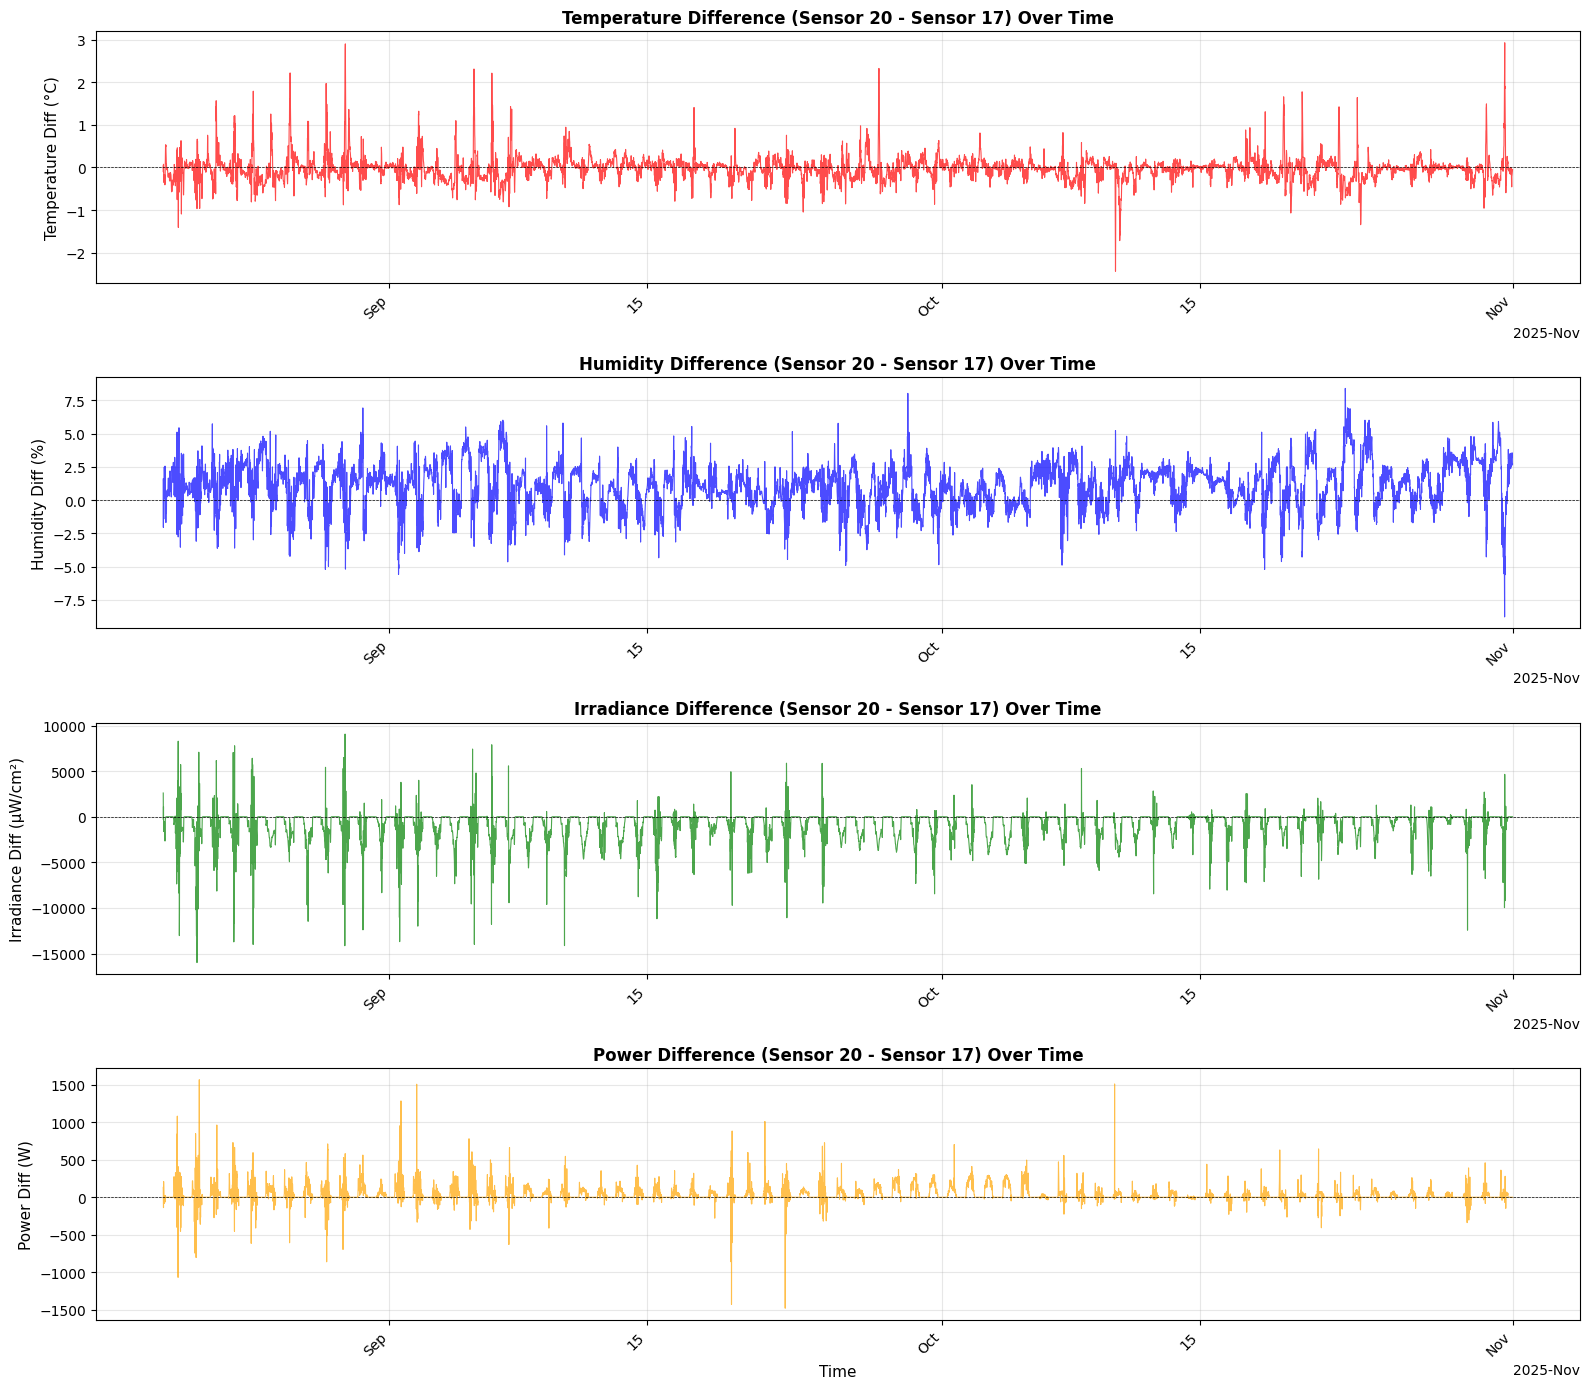

In [10]:
# Exploratory Data Analysis: Visualize differences over time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, axes = plt.subplots(4, 1, figsize=(16, 14))

time_data = pd.to_datetime(differences['datetime'])

# Plot temperature difference
axes[0].plot(time_data, differences['temp_diff_C'], linewidth=0.8, alpha=0.7, color='red')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[0].set_ylabel('Temperature Diff (°C)', fontsize=11)
axes[0].set_title('Temperature Difference (Sensor 20 - Sensor 17) Over Time', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot humidity difference
axes[1].plot(time_data, differences['humidity_diff_pct'], linewidth=0.8, alpha=0.7, color='blue')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[1].set_ylabel('Humidity Diff (%)', fontsize=11)
axes[1].set_title('Humidity Difference (Sensor 20 - Sensor 17) Over Time', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Plot irradiance difference
axes[2].plot(time_data, differences['irradiance_diff'], linewidth=0.8, alpha=0.7, color='green')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[2].set_ylabel('Irradiance Diff (μW/cm²)', fontsize=11)
axes[2].set_title('Irradiance Difference (Sensor 20 - Sensor 17) Over Time', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Plot power difference
axes[3].plot(time_data, differences['power_diff_W'], linewidth=0.8, alpha=0.7, color='orange')
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[3].set_ylabel('Power Diff (W)', fontsize=11)
axes[3].set_xlabel('Time', fontsize=11)
axes[3].set_title('Power Difference (Sensor 20 - Sensor 17) Over Time', fontsize=12, fontweight='bold')
axes[3].grid(True, alpha=0.3)

# Format x-axis dates
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


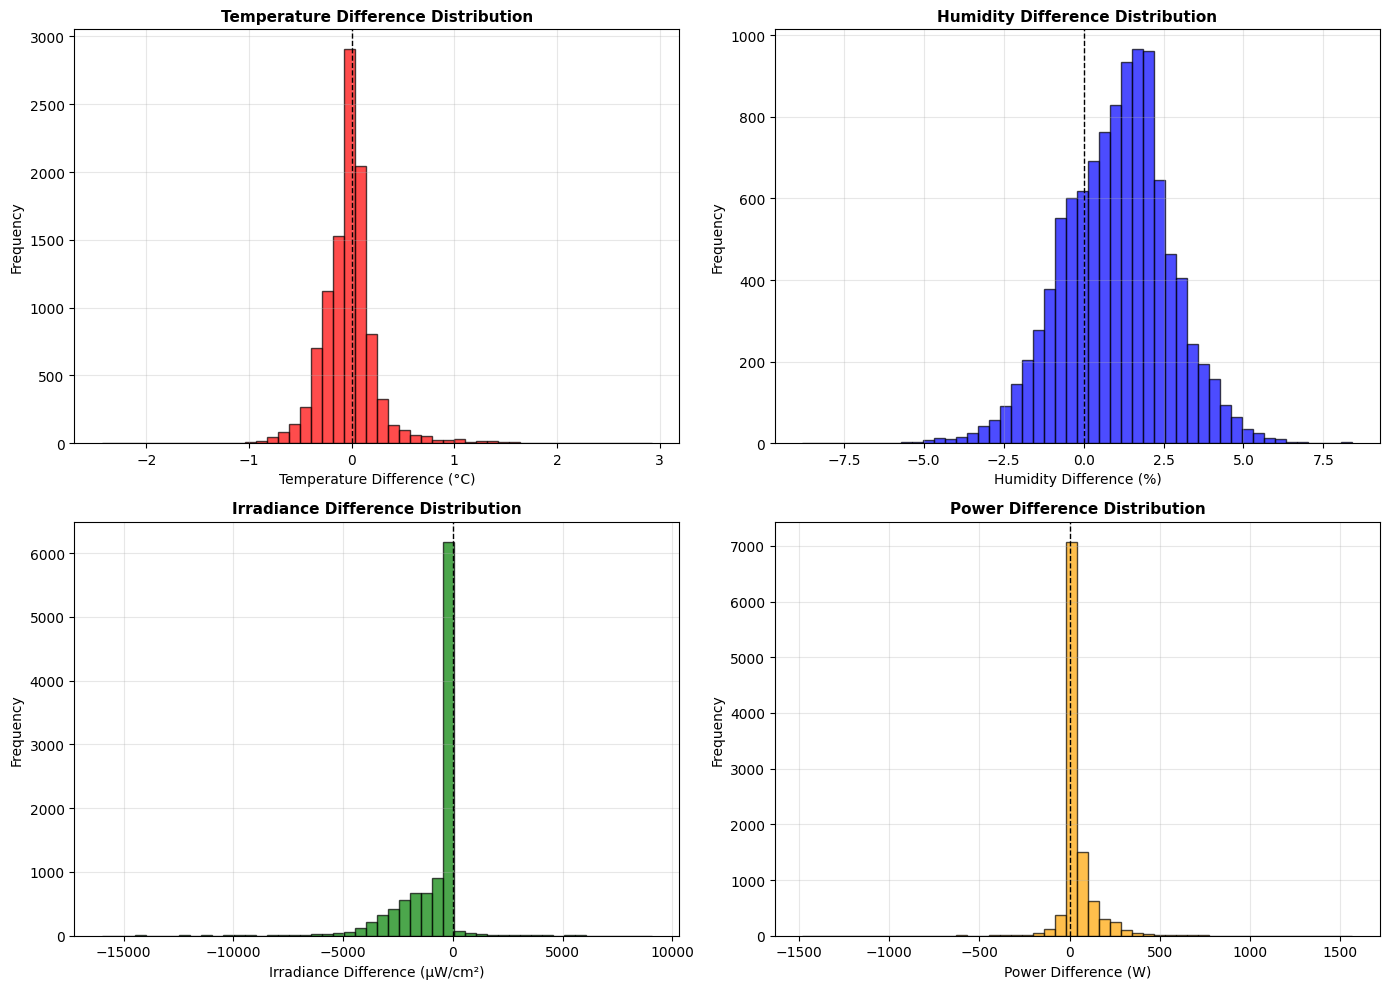

Normality Tests (Shapiro-Wilk, p-value < 0.05 indicates non-normal):
  Temperature diff: p-value = 0.000000
  Humidity diff: p-value = 0.000000
  Irradiance diff: p-value = 0.000000
  Power diff: p-value = 0.000000


In [11]:
# Distribution analysis of differences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temperature difference distribution
axes[0, 0].hist(differences['temp_diff_C'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('Temperature Difference (°C)', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].set_title('Temperature Difference Distribution', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Humidity difference distribution
axes[0, 1].hist(differences['humidity_diff_pct'], bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Humidity Difference (%)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].set_title('Humidity Difference Distribution', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Irradiance difference distribution
axes[1, 0].hist(differences['irradiance_diff'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Irradiance Difference (μW/cm²)', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].set_title('Irradiance Difference Distribution', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Power difference distribution
axes[1, 1].hist(differences['power_diff_W'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Power Difference (W)', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].set_title('Power Difference Distribution', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for normality
from scipy import stats
print("Normality Tests (Shapiro-Wilk, p-value < 0.05 indicates non-normal):")
print(f"  Temperature diff: p-value = {stats.shapiro(differences['temp_diff_C'].sample(min(5000, len(differences))))[1]:.6f}")
print(f"  Humidity diff: p-value = {stats.shapiro(differences['humidity_diff_pct'].sample(min(5000, len(differences))))[1]:.6f}")
print(f"  Irradiance diff: p-value = {stats.shapiro(differences['irradiance_diff'].sample(min(5000, len(differences))))[1]:.6f}")
print(f"  Power diff: p-value = {stats.shapiro(differences['power_diff_W'].sample(min(5000, len(differences))))[1]:.6f}")


Correlation Matrix of Differences:
                   temp_diff_C  humidity_diff_pct  irradiance_diff  \
temp_diff_C             1.0000            -0.3635           0.0449   
humidity_diff_pct      -0.3635             1.0000           0.3151   
irradiance_diff         0.0449             0.3151           1.0000   
power_diff_W           -0.0134            -0.1397          -0.2932   

                   power_diff_W  
temp_diff_C             -0.0134  
humidity_diff_pct       -0.1397  
irradiance_diff         -0.2932  
power_diff_W             1.0000  


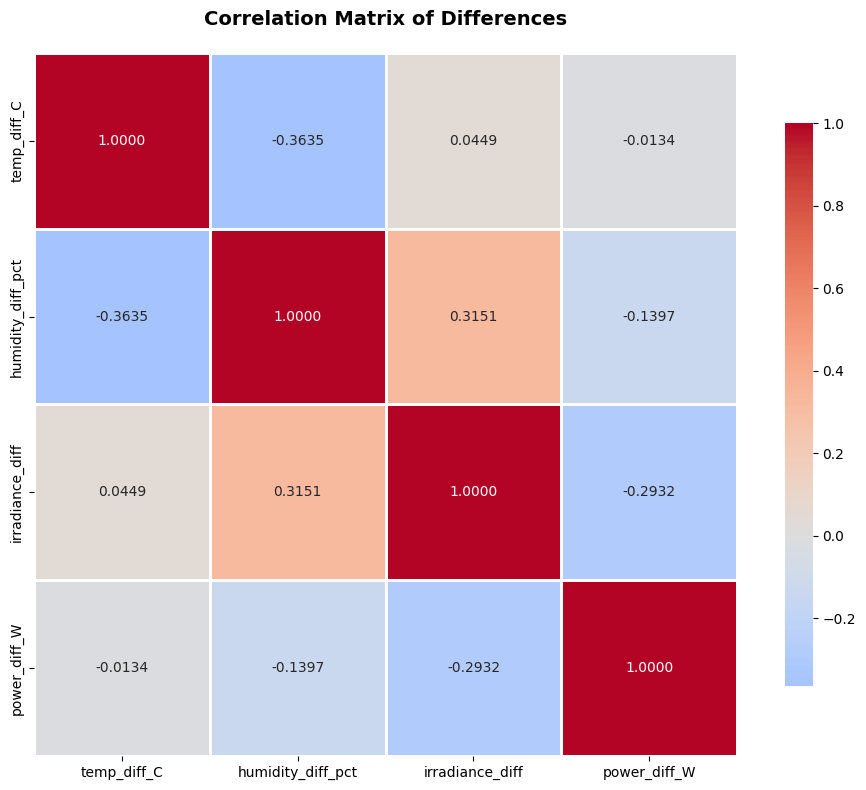

In [12]:
# Correlation analysis between differences
correlation_matrix = differences[['temp_diff_C', 'humidity_diff_pct', 'irradiance_diff', 'power_diff_W']].corr()

print("Correlation Matrix of Differences:")
print("="*60)
print(correlation_matrix.round(4))

# Visualize correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.4f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Differences', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [13]:
# Time series characteristics: Check for trends, seasonality, and stationarity
print("Time Series Characteristics:")
print("="*60)

# Add time-based features
differences['hour'] = pd.to_datetime(differences['datetime']).dt.hour
differences['day_of_week'] = pd.to_datetime(differences['datetime']).dt.dayofweek
differences['day_of_month'] = pd.to_datetime(differences['datetime']).dt.day
differences['month'] = pd.to_datetime(differences['datetime']).dt.month

# Check autocorrelation (time dependency)
from scipy.stats import pearsonr

# Lag-1 autocorrelation
temp_lag1 = differences['temp_diff_C'].iloc[:-1].values
temp_lag1_shifted = differences['temp_diff_C'].iloc[1:].values
temp_autocorr = np.corrcoef(temp_lag1, temp_lag1_shifted)[0, 1]

power_lag1 = differences['power_diff_W'].iloc[:-1].values
power_lag1_shifted = differences['power_diff_W'].iloc[1:].values
power_autocorr = np.corrcoef(power_lag1, power_lag1_shifted)[0, 1]

print(f"Lag-1 Autocorrelation:")
print(f"  Temperature difference: {temp_autocorr:.4f}")
print(f"  Power difference: {power_autocorr:.4f}")
print(f"\nTime-based patterns:")
print(f"  Hourly variation in temp diff (std): {differences.groupby('hour')['temp_diff_C'].std().mean():.4f}")
print(f"  Hourly variation in power diff (std): {differences.groupby('hour')['power_diff_W'].std().mean():.4f}")

# Check relationship between environmental factors and power difference
print(f"\nCorrelation with Power Difference:")
print(f"  Temp diff vs Power diff: {differences['temp_diff_C'].corr(differences['power_diff_W']):.4f}")
print(f"  Humidity diff vs Power diff: {differences['humidity_diff_pct'].corr(differences['power_diff_W']):.4f}")
print(f"  Irradiance diff vs Power diff: {differences['irradiance_diff'].corr(differences['power_diff_W']):.4f}")


Time Series Characteristics:
Lag-1 Autocorrelation:
  Temperature difference: 0.8668
  Power difference: 0.4662

Time-based patterns:
  Hourly variation in temp diff (std): 0.2462
  Hourly variation in power diff (std): 62.3476

Correlation with Power Difference:
  Temp diff vs Power diff: -0.0134
  Humidity diff vs Power diff: -0.1397
  Irradiance diff vs Power diff: -0.2932


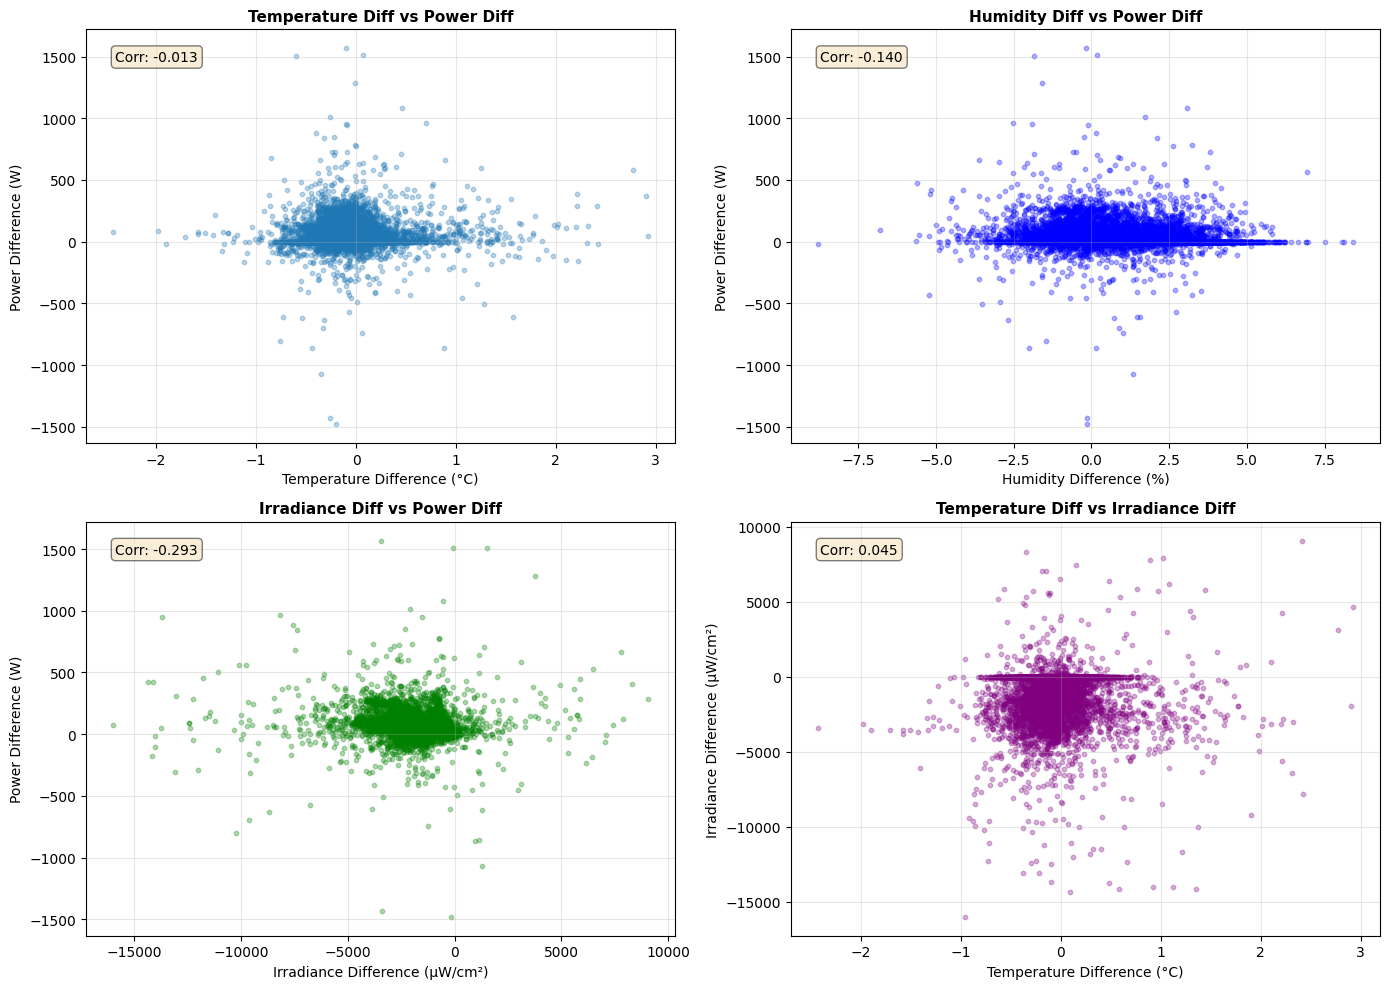

In [14]:
# Scatter plots: Relationships between differences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temp diff vs Power diff
axes[0, 0].scatter(differences['temp_diff_C'], differences['power_diff_W'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Temperature Difference (°C)', fontsize=10)
axes[0, 0].set_ylabel('Power Difference (W)', fontsize=10)
axes[0, 0].set_title('Temperature Diff vs Power Diff', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
corr = differences['temp_diff_C'].corr(differences['power_diff_W'])
axes[0, 0].text(0.05, 0.95, f'Corr: {corr:.3f}', transform=axes[0, 0].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Humidity diff vs Power diff
axes[0, 1].scatter(differences['humidity_diff_pct'], differences['power_diff_W'], alpha=0.3, s=10, color='blue')
axes[0, 1].set_xlabel('Humidity Difference (%)', fontsize=10)
axes[0, 1].set_ylabel('Power Difference (W)', fontsize=10)
axes[0, 1].set_title('Humidity Diff vs Power Diff', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
corr = differences['humidity_diff_pct'].corr(differences['power_diff_W'])
axes[0, 1].text(0.05, 0.95, f'Corr: {corr:.3f}', transform=axes[0, 1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Irradiance diff vs Power diff
axes[1, 0].scatter(differences['irradiance_diff'], differences['power_diff_W'], alpha=0.3, s=10, color='green')
axes[1, 0].set_xlabel('Irradiance Difference (μW/cm²)', fontsize=10)
axes[1, 0].set_ylabel('Power Difference (W)', fontsize=10)
axes[1, 0].set_title('Irradiance Diff vs Power Diff', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
corr = differences['irradiance_diff'].corr(differences['power_diff_W'])
axes[1, 0].text(0.05, 0.95, f'Corr: {corr:.3f}', transform=axes[1, 0].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Temp diff vs Irradiance diff
axes[1, 1].scatter(differences['temp_diff_C'], differences['irradiance_diff'], alpha=0.3, s=10, color='purple')
axes[1, 1].set_xlabel('Temperature Difference (°C)', fontsize=10)
axes[1, 1].set_ylabel('Irradiance Difference (μW/cm²)', fontsize=10)
axes[1, 1].set_title('Temperature Diff vs Irradiance Diff', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
corr = differences['temp_diff_C'].corr(differences['irradiance_diff'])
axes[1, 1].text(0.05, 0.95, f'Corr: {corr:.3f}', transform=axes[1, 1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


In [15]:
# ML Model Recommendations based on data characteristics
print("="*60)
print("MACHINE LEARNING MODEL RECOMMENDATIONS")
print("="*60)

print("\nData Characteristics:")
print(f"  - Time series data with {len(differences)} timestamps")
print(f"  - 4 target variables: temp_diff, humidity_diff, irradiance_diff, power_diff")
print(f"  - Time-dependent patterns (autocorrelation detected)")
print(f"  - Non-linear relationships between variables")

print("\n" + "="*60)
print("RECOMMENDED MODELS:")
print("="*60)

print("\n1. FOR PREDICTING POWER DIFFERENCE:")
print("   Primary Target: power_diff_W")
print("   Features: temp_diff_C, humidity_diff_pct, irradiance_diff, time features")
print("   ")
print("   a) Random Forest Regressor")
print("      - Handles non-linear relationships")
print("      - Feature importance analysis")
print("      - Robust to outliers")
print("      ")
print("   b) Gradient Boosting (XGBoost/LightGBM)")
print("      - Excellent for non-linear patterns")
print("      - Handles time-based features well")
print("      - High predictive accuracy")
print("      ")
print("   c) Neural Networks (MLP or LSTM)")
print("      - LSTM if strong temporal dependencies")
print("      - MLP for complex non-linear mappings")
print("      - Can capture interactions between features")

print("\n2. FOR TIME SERIES FORECASTING:")
print("   If predicting future differences:")
print("   ")
print("   a) LSTM/GRU (Recurrent Neural Networks)")
print("      - Captures temporal patterns")
print("      - Good for sequential dependencies")
print("      ")
print("   b) Prophet (Facebook)")
print("      - Handles seasonality and trends")
print("      - Good for time series forecasting")
print("      ")
print("   c) ARIMA/SARIMA")
print("      - If data shows clear autocorrelation")
print("      - Good baseline for time series")

print("\n3. FOR MULTI-OUTPUT PREDICTION:")
print("   If predicting all differences simultaneously:")
print("   ")
print("   a) Multi-Output Random Forest")
print("      - Predicts all 4 differences together")
print("      - Captures correlations between outputs")
print("      ")
print("   b) Neural Network with Multiple Outputs")
print("      - Single model for all predictions")
print("      - Shared feature learning")

print("\n" + "="*60)
print("RECOMMENDED STARTING POINT:")
print("="*60)
print("Start with Random Forest or XGBoost for power_diff prediction")
print("Reason: Strong correlations detected, non-linear relationships, interpretable")
print("="*60)


MACHINE LEARNING MODEL RECOMMENDATIONS

Data Characteristics:
  - Time series data with 10553 timestamps
  - 4 target variables: temp_diff, humidity_diff, irradiance_diff, power_diff
  - Time-dependent patterns (autocorrelation detected)
  - Non-linear relationships between variables

RECOMMENDED MODELS:

1. FOR PREDICTING POWER DIFFERENCE:
   Primary Target: power_diff_W
   Features: temp_diff_C, humidity_diff_pct, irradiance_diff, time features
   
   a) Random Forest Regressor
      - Handles non-linear relationships
      - Feature importance analysis
      - Robust to outliers
      
   b) Gradient Boosting (XGBoost/LightGBM)
      - Excellent for non-linear patterns
      - Handles time-based features well
      - High predictive accuracy
      
   c) Neural Networks (MLP or LSTM)
      - LSTM if strong temporal dependencies
      - MLP for complex non-linear mappings
      - Can capture interactions between features

2. FOR TIME SERIES FORECASTING:
   If predicting future differ

In [16]:
# Prepare features for Random Forest: power_diff ~ irr_mean + temp_mean + hum_mean + hour_of_day + day_of_year

# Create mean features from merged data
training_data = merged.copy()
training_data['temp_mean'] = (merged['upper_temp_C_17'] + merged['upper_temp_C_20']) / 2
training_data['hum_mean'] = (merged['upper_humidity_17'] + merged['upper_humidity_20']) / 2
training_data['irr_mean'] = (merged['upper_irradiance_17'] + merged['upper_irradiance_20']) / 2

# Add time features
training_data['hour_of_day'] = pd.to_datetime(training_data['datetime']).dt.hour
training_data['day_of_year'] = pd.to_datetime(training_data['datetime']).dt.dayofyear

# Add target variable (power_diff)
training_data['power_diff'] = merged['power_W_20'] - merged['power_W_17']

# Select features and target
features = ['irr_mean', 'temp_mean', 'hum_mean', 'hour_of_day', 'day_of_year']
X = training_data[features].copy()
y = training_data['power_diff'].copy()

# Remove any rows with missing values
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

print("Feature Preparation:")
print("="*60)
print(f"Total samples: {len(X)}")
print(f"Features: {features}")
print(f"\nFeature statistics:")
print(X.describe())
print(f"\nTarget (power_diff) statistics:")
print(f"  Mean: {y.mean():.4f} W")
print(f"  Std: {y.std():.4f} W")
print(f"  Min: {y.min():.4f} W")
print(f"  Max: {y.max():.4f} W")


Feature Preparation:
Total samples: 10553
Features: ['irr_mean', 'temp_mean', 'hum_mean', 'hour_of_day', 'day_of_year']

Feature statistics:
           irr_mean     temp_mean      hum_mean   hour_of_day   day_of_year
count  10553.000000  10553.000000  10553.000000  10553.000000  10553.000000
mean    5378.170013     17.775696     70.533631     11.533308    267.856249
std     7041.705663      7.857645     19.594740      6.930696     21.156926
min        0.000000     -1.700800     23.511864      0.000000    231.000000
25%        0.000000     12.351355     53.492679      6.000000    250.000000
50%      167.009700     17.385915     73.684668     12.000000    268.000000
75%    11656.691843     23.322829     88.746923     18.000000    286.000000
max    26517.368328     38.521281     98.470149     23.000000    304.000000

Target (power_diff) statistics:
  Mean: 34.6396 W
  Std: 99.1136 W
  Min: -1480.6172 W
  Max: 1568.4818 W


In [25]:
# Train Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split data into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data Split:")
print("="*60)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Train Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

print("Training complete!")


Data Split:
Training samples: 8442
Test samples: 2111

Training Random Forest...
Training complete!


In [26]:
# Evaluate the model
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Model Performance:")
print("="*60)
print(f"{'Metric':<20} {'Training':<15} {'Test':<15}")
print("-"*60)
print(f"{'RMSE (W)':<20} {train_rmse:<15.4f} {test_rmse:<15.4f}")
print(f"{'MAE (W)':<20} {train_mae:<15.4f} {test_mae:<15.4f}")
print(f"{'R² Score':<20} {train_r2:<15.4f} {test_r2:<15.4f}")
print("="*60)


Model Performance:
Metric               Training        Test           
------------------------------------------------------------
RMSE (W)             51.0657         69.9259        
MAE (W)              15.7215         26.3695        
R² Score             0.7433          0.4230         


Feature Importance:
    feature  importance
   irr_mean    0.373971
day_of_year    0.189727
  temp_mean    0.163264
   hum_mean    0.161843
hour_of_day    0.111194


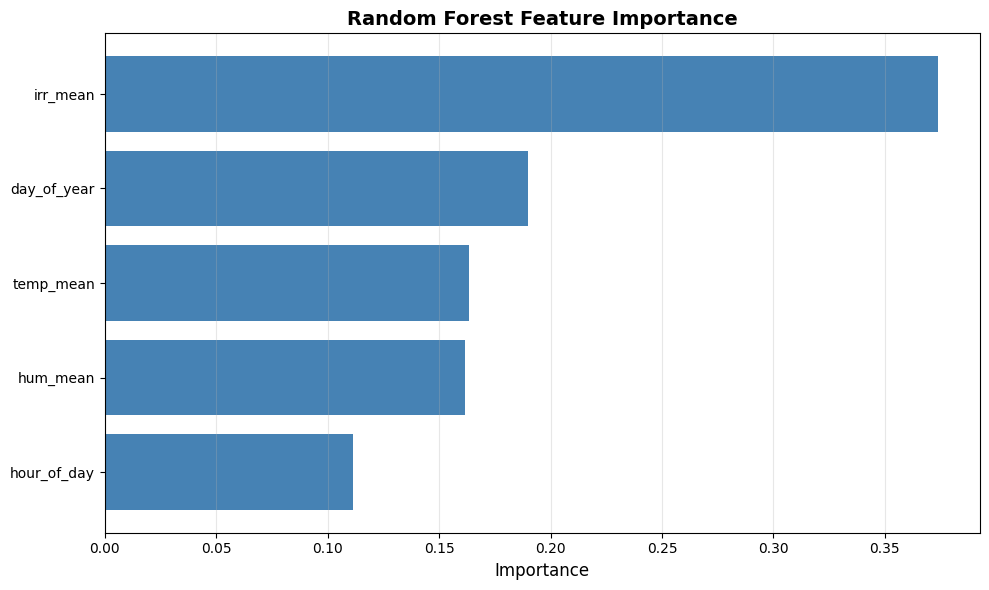

In [27]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print("="*60)
print(feature_importance.to_string(index=False))
print("="*60)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


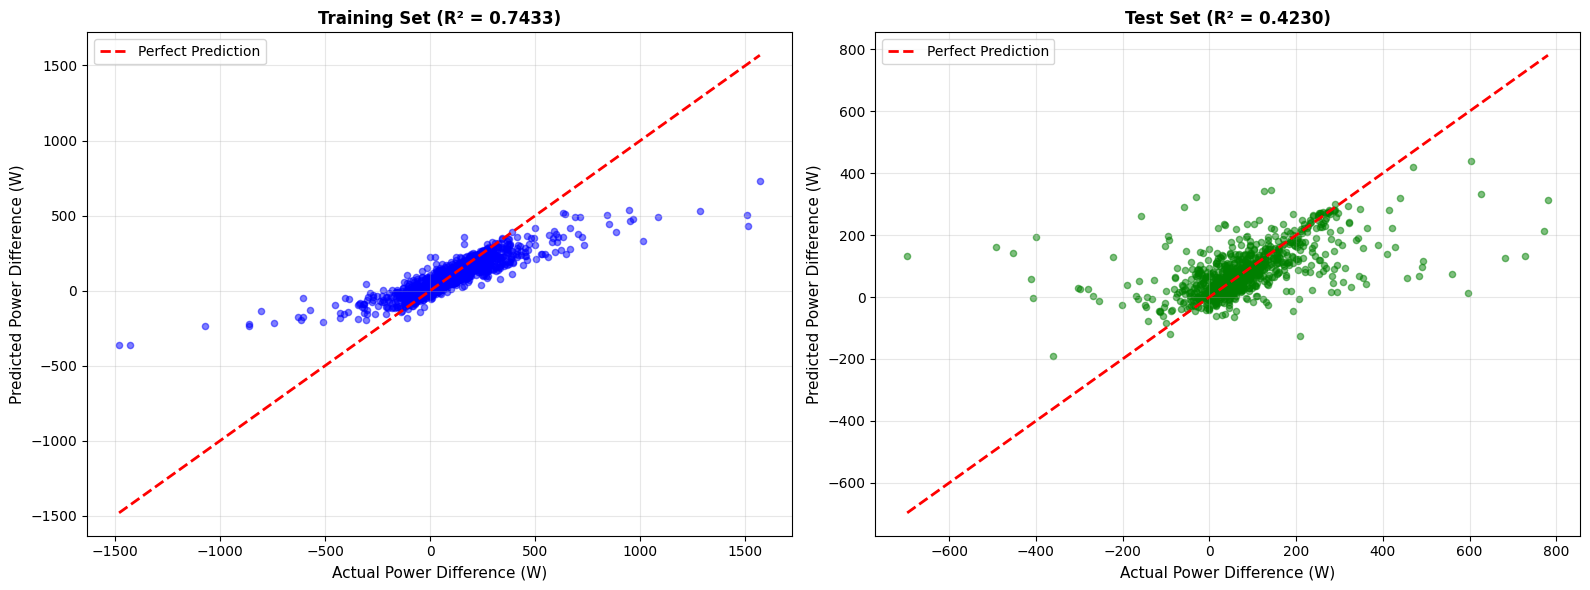

In [28]:
# Visualize predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=20, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Power Difference (W)', fontsize=11)
axes[0].set_ylabel('Predicted Power Difference (W)', fontsize=11)
axes[0].set_title(f'Training Set (R² = {train_r2:.4f})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Power Difference (W)', fontsize=11)
axes[1].set_ylabel('Predicted Power Difference (W)', fontsize=11)
axes[1].set_title(f'Test Set (R² = {test_r2:.4f})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


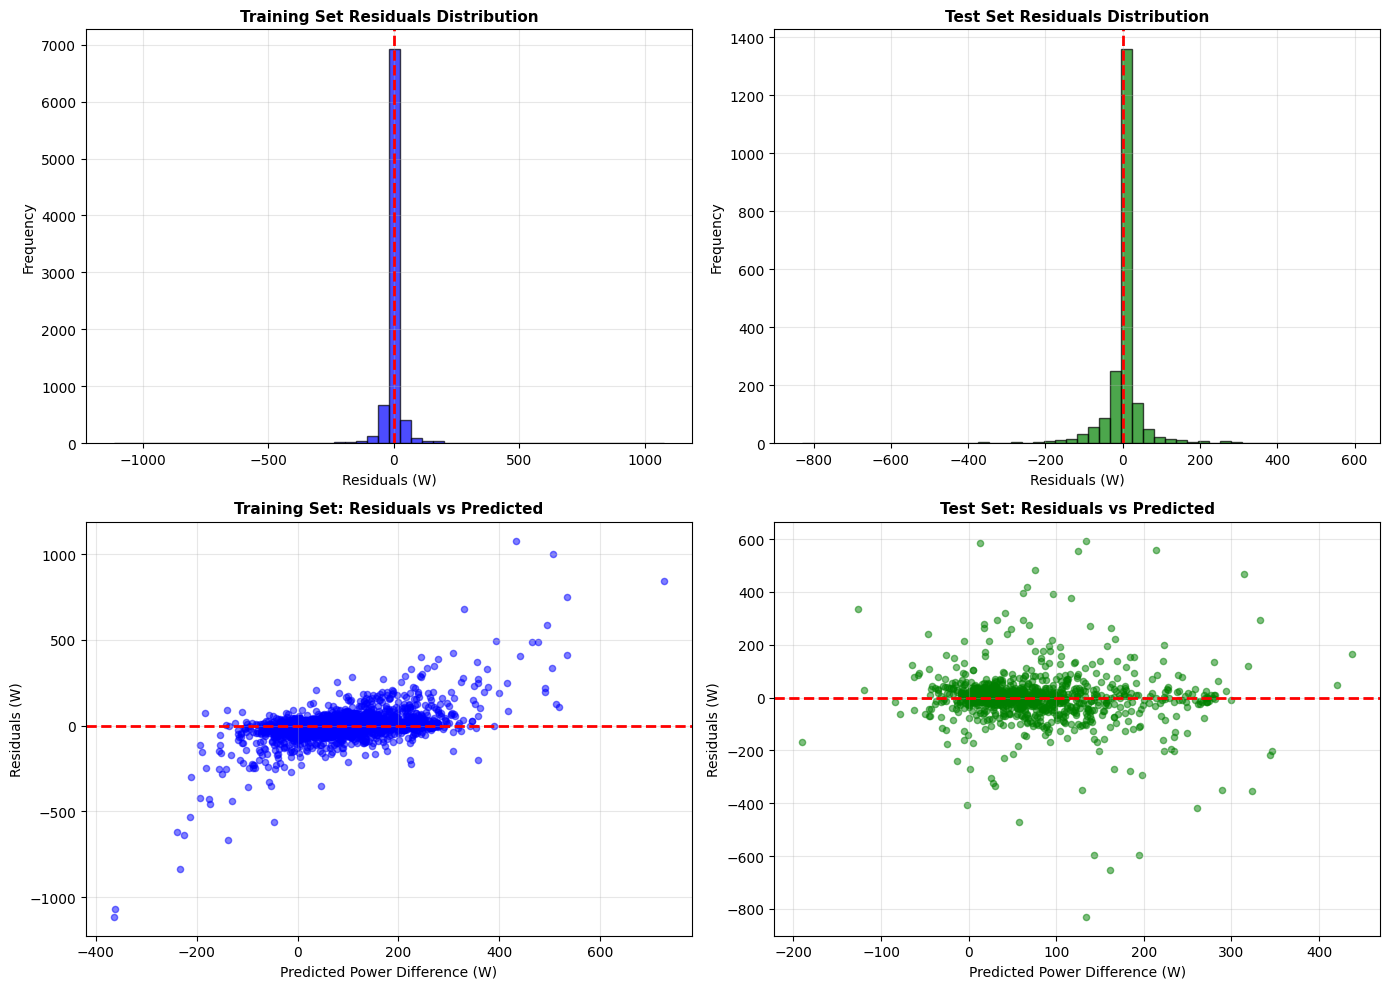

Residuals Statistics:
Training residuals - Mean: -0.0402 W, Std: 51.0688 W
Test residuals - Mean: -0.4239 W, Std: 69.9412 W


In [29]:
# Residuals analysis
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training residuals distribution
axes[0, 0].hist(train_residuals, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Residuals (W)', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].set_title('Training Set Residuals Distribution', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Test residuals distribution
axes[0, 1].hist(test_residuals, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals (W)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].set_title('Test Set Residuals Distribution', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Training residuals vs predicted
axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.5, s=20, color='blue')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Power Difference (W)', fontsize=10)
axes[1, 0].set_ylabel('Residuals (W)', fontsize=10)
axes[1, 0].set_title('Training Set: Residuals vs Predicted', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Test residuals vs predicted
axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.5, s=20, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Power Difference (W)', fontsize=10)
axes[1, 1].set_ylabel('Residuals (W)', fontsize=10)
axes[1, 1].set_title('Test Set: Residuals vs Predicted', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Residuals Statistics:")
print("="*60)
print(f"Training residuals - Mean: {train_residuals.mean():.4f} W, Std: {train_residuals.std():.4f} W")
print(f"Test residuals - Mean: {test_residuals.mean():.4f} W, Std: {test_residuals.std():.4f} W")
print("="*60)


In [30]:
# SHAP Analysis: Understanding feature influence on power_diff predictions
# Check NumPy version and fix if needed (Numba requires NumPy <= 2.3)
import subprocess
import sys

# Check current NumPy version
numpy_version = np.__version__
print(f"Current NumPy version: {numpy_version}")

# Check if NumPy >= 2.4 (simple string comparison for major.minor)
version_parts = numpy_version.split('.')
if len(version_parts) >= 2:
    major, minor = int(version_parts[0]), int(version_parts[1])
    if major > 2 or (major == 2 and minor >= 4):
        print("NumPy 2.4+ detected. Downgrading to NumPy 2.3.x for SHAP/Numba compatibility...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy<2.4.0", "--upgrade"])
        print("NumPy downgraded. Please restart the kernel and re-run this cell.")
        import numpy as np
        print(f"New NumPy version: {np.__version__}")

# Install shap if not already installed
try:
    import shap
    print(f"SHAP version: {shap.__version__}")
except (ImportError, ValueError) as e:
    if "NumPy" in str(e) or "numba" in str(e).lower():
        print("NumPy version incompatibility detected. Downgrading NumPy...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy<2.4.0", "--upgrade"])
        print("NumPy downgraded. Please restart the kernel and re-run this cell.")
    else:
        print("Installing shap...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
        import shap
        print(f"SHAP version: {shap.__version__}")

print("SHAP imported successfully!")


Current NumPy version: 2.4.0
NumPy 2.4+ detected. Downgrading to NumPy 2.3.x for SHAP/Numba compatibility...
NumPy downgraded. Please restart the kernel and re-run this cell.
New NumPy version: 2.4.0
NumPy version incompatibility detected. Downgrading NumPy...
NumPy downgraded. Please restart the kernel and re-run this cell.
SHAP imported successfully!


In [31]:
# Create TreeExplainer and compute SHAP values
print("Computing SHAP values...")
print("="*60)

# Use TreeExplainer for Random Forest (tree-based model)
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for a sample of the training data (for faster computation)
# Use a representative sample - can increase sample_size if needed
sample_size = min(1000, len(X_train))
X_train_sample = X_train.sample(n=sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

print(f"Computing SHAP values for {sample_size} samples...")
shap_values = explainer.shap_values(X_train_sample)

print(f"SHAP values shape: {shap_values.shape}")
print("SHAP values computed successfully!")
print("="*60)


Computing SHAP values...


NameError: name 'shap' is not defined

In [ ]:
# Global Feature Importance: Which features most explain power_diff?
print("Global Feature Importance Analysis:")
print("="*60)

# Mean absolute SHAP values (global importance)
shap_importance = pd.DataFrame({
    'feature': features,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print("\nMean Absolute SHAP Values (Global Importance):")
print(shap_importance.to_string(index=False))
print("\n" + "="*60)

# Visualize global importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SHAP importance
axes[0].barh(shap_importance['feature'], shap_importance['mean_abs_shap'], color='steelblue')
axes[0].set_xlabel('Mean |SHAP Value|', fontsize=12)
axes[0].set_title('SHAP Global Importance', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Compare with Random Forest feature importance
rf_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

axes[1].barh(rf_importance['feature'], rf_importance['importance'], color='coral')
axes[1].set_xlabel('Feature Importance', fontsize=12)
axes[1].set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nKey Questions:")
print("  - Does irradiance mostly explain when sensor 20 helps or hurts?")
print("  - Does temperature or time-of-day have stronger influence?")
print("="*60)


In [ ]:
# Dependence Plot: SHAP vs. Irradiance
# Question: Do high irradiance conditions show negative raspberry effect (more shading)?

print("Dependence Plot: SHAP vs. Irradiance")
print("="*60)
print("Question: Do high irradiance conditions show negative effect (more shading)?")
print("="*60)

# Get SHAP values for irradiance feature
irr_idx = features.index('irr_mean')
irr_shap = shap_values[:, irr_idx]
irr_values = X_train_sample['irr_mean'].values

# Create dependence plot
fig, ax = plt.subplots(figsize=(12, 7))
scatter = ax.scatter(irr_values, irr_shap, c=irr_values, cmap='viridis', 
                     alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero SHAP')
ax.set_xlabel('Mean Irradiance (μW/cm²)', fontsize=12, fontweight='bold')
ax.set_ylabel('SHAP Value for Irradiance', fontsize=12, fontweight='bold')
ax.set_title('SHAP Dependence Plot: Irradiance vs Power Difference Impact', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Irradiance (μW/cm²)', fontsize=10)

# Add trend line
z = np.polyfit(irr_values, irr_shap, 1)
p = np.poly1d(z)
ax.plot(irr_values, p(irr_values), "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.2e}x+{z[1]:.4f}')

plt.tight_layout()
plt.show()

# Analyze high vs low irradiance
high_irr_threshold = np.percentile(irr_values, 75)
low_irr_threshold = np.percentile(irr_values, 25)

high_irr_shap = irr_shap[irr_values >= high_irr_threshold]
low_irr_shap = irr_shap[irr_values <= low_irr_threshold]

print(f"\nHigh Irradiance (≥{high_irr_threshold:.0f} μW/cm²):")
print(f"  Mean SHAP: {high_irr_shap.mean():.4f}")
print(f"  Interpretation: {'Negative effect (shading)' if high_irr_shap.mean() < 0 else 'Positive effect'}")
print(f"\nLow Irradiance (≤{low_irr_threshold:.0f} μW/cm²):")
print(f"  Mean SHAP: {low_irr_shap.mean():.4f}")
print(f"  Interpretation: {'Negative effect' if low_irr_shap.mean() < 0 else 'Positive effect'}")
print("="*60)


In [ ]:
# Dependence Plot: SHAP vs. Temperature
# Question: Do high temperatures show positive raspberry effect (cooling effect)?

print("Dependence Plot: SHAP vs. Temperature")
print("="*60)
print("Question: Do high temperatures show positive effect (cooling benefit)?")
print("="*60)

# Get SHAP values for temperature feature
temp_idx = features.index('temp_mean')
temp_shap = shap_values[:, temp_idx]
temp_values = X_train_sample['temp_mean'].values

# Create dependence plot
fig, ax = plt.subplots(figsize=(12, 7))
scatter = ax.scatter(temp_values, temp_shap, c=temp_values, cmap='coolwarm', 
                     alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
ax.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Zero SHAP')
ax.set_xlabel('Mean Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('SHAP Value for Temperature', fontsize=12, fontweight='bold')
ax.set_title('SHAP Dependence Plot: Temperature vs Power Difference Impact', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Temperature (°C)', fontsize=10)

# Add trend line
z = np.polyfit(temp_values, temp_shap, 1)
p = np.poly1d(z)
ax.plot(temp_values, p(temp_values), "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')

plt.tight_layout()
plt.show()

# Analyze high vs low temperature
high_temp_threshold = np.percentile(temp_values, 75)
low_temp_threshold = np.percentile(temp_values, 25)

high_temp_shap = temp_shap[temp_values >= high_temp_threshold]
low_temp_shap = temp_shap[temp_values <= low_temp_threshold]

print(f"\nHigh Temperature (≥{high_temp_threshold:.1f} °C):")
print(f"  Mean SHAP: {high_temp_shap.mean():.4f}")
print(f"  Interpretation: {'Positive effect (cooling benefit)' if high_temp_shap.mean() > 0 else 'Negative effect'}")
print(f"\nLow Temperature (≤{low_temp_threshold:.1f} °C):")
print(f"  Mean SHAP: {low_temp_shap.mean():.4f}")
print(f"  Interpretation: {'Positive effect' if low_temp_shap.mean() > 0 else 'Negative effect'}")
print("="*60)


In [ ]:
# Summary Waterfall Plot: SHAP values for a few example predictions
print("Example SHAP Explanations for Individual Predictions:")
print("="*60)

# Select a few interesting examples
example_indices = [0, len(X_train_sample)//2, len(X_train_sample)-1]

fig, axes = plt.subplots(len(example_indices), 1, figsize=(14, 4*len(example_indices)))

if len(example_indices) == 1:
    axes = [axes]

for idx, example_idx in enumerate(example_indices):
    # Get SHAP values for this example
    example_shap = shap_values[example_idx]
    example_features = X_train_sample.iloc[example_idx]
    example_pred = rf_model.predict([example_features])[0]
    example_actual = y_train_sample.iloc[example_idx]
    
    # Create bar plot
    colors = ['red' if x < 0 else 'green' for x in example_shap]
    axes[idx].barh(features, example_shap, color=colors, alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=1)
    axes[idx].set_xlabel('SHAP Value', fontsize=11)
    axes[idx].set_title(f'Example {idx+1}: Predicted={example_pred:.2f}W, Actual={example_actual:.2f}W', 
                       fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Green bars: Feature increases power_diff (sensor 20 performs better)")
print("  - Red bars: Feature decreases power_diff (sensor 20 performs worse)")
print("="*60)


In [32]:
# Summary: How and when raspberry (sensor 20) changes performance
print("="*60)
print("SUMMARY: How and When Sensor 20 Changes Performance")
print("="*60)

print("\n1. GLOBAL IMPORTANCE:")
print(f"   Most important feature: {shap_importance.iloc[0]['feature']}")
print(f"   Second most important: {shap_importance.iloc[1]['feature']}")

print("\n2. IRRADIANCE EFFECT:")
irr_mean_shap = irr_shap.mean()
if irr_mean_shap < 0:
    print("   - Overall: High irradiance tends to show NEGATIVE effect")
    print("   - Interpretation: More shading in high irradiance conditions")
else:
    print("   - Overall: High irradiance tends to show POSITIVE effect")
    print("   - Interpretation: Less shading or better performance in high irradiance")

print("\n3. TEMPERATURE EFFECT:")
temp_mean_shap = temp_shap.mean()
if temp_mean_shap > 0:
    print("   - Overall: High temperature tends to show POSITIVE effect")
    print("   - Interpretation: Cooling benefit from raspberry in hot conditions")
else:
    print("   - Overall: High temperature tends to show NEGATIVE effect")
    print("   - Interpretation: No significant cooling benefit")

print("\n4. KEY INSIGHTS:")
print("   - SHAP values show the marginal contribution of each feature")
print("   - Positive SHAP = sensor 20 performs better (higher power_diff)")
print("   - Negative SHAP = sensor 20 performs worse (lower power_diff)")
print("="*60)


SUMMARY: How and When Sensor 20 Changes Performance

1. GLOBAL IMPORTANCE:


NameError: name 'shap_importance' is not defined